In [17]:
from trainer import train_SPIDER
import os, pickle, pandas as pd
import scanpy as sc, numpy as np
import utils, sklearn
from sklearn.metrics import normalized_mutual_info_score, homogeneity_score
from sklearn.metrics.cluster import adjusted_rand_score

In [5]:
with open("/data/istiaq/work/projects/DUSTED/tutorial/data/DLPFC_data.pickle", "rb") as f:
    loaded = pickle.load(f)
std, psd = loaded["realST"], loaded["pseudoST"]

In [ ]:
import importlib
importlib.reload(utils)

In [6]:
params = {'W_recon': 3.5611961149150226, 'W_mmd': 1.109798809633746, 'W_cell': 1.280970162059623, 'k_cutoff': 9, 'lr': 0.0004790792935102623}
k_cutoff = params["k_cutoff"]
rad_cutoff = std.uns['rad_cutoff']
utils.Cal_knn_expression(std, k_cutoff=k_cutoff)
utils.Cal_knn_expression(psd, k_cutoff=k_cutoff)
utils.Cal_Spatial_Net(std, rad_cutoff=rad_cutoff)

------Calculating Similarity Graph...
The graph contains 33558 edges, 3611 cells.
9.2933 neighbors per cell on average.
------Calculating Similarity Graph...
The graph contains 37463 edges, 4000 cells.
9.3658 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 30298 edges, 3611 cells.
8.3905 neighbors per cell on average.


[Local deterministic seed set to 3156]
Size of Input:  (3611, 3000)


100%|██████████| 500/500 [01:15<00:00,  6.58it/s]


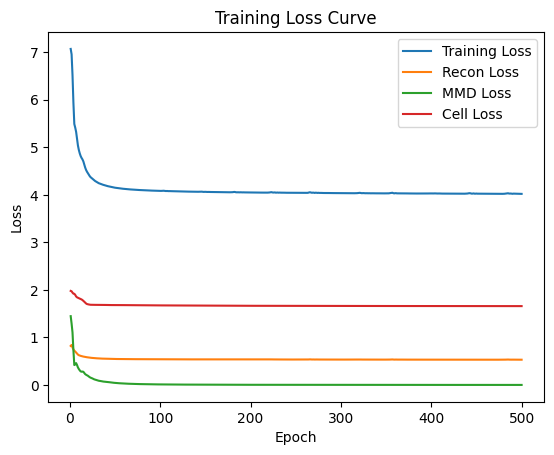

In [8]:
std,model = train_SPIDER(std, psd, key_added='SPIDER',lr=params["lr"],n_epochs=500,device='cuda:2',random_seed=3156,
                                W_recon=params["W_recon"],W_mmd=params["W_mmd"],W_cell=params["W_cell"])

/home/istiaq/anaconda3/envs/dusted/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/istiaq/anaconda3/envs/dusted/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


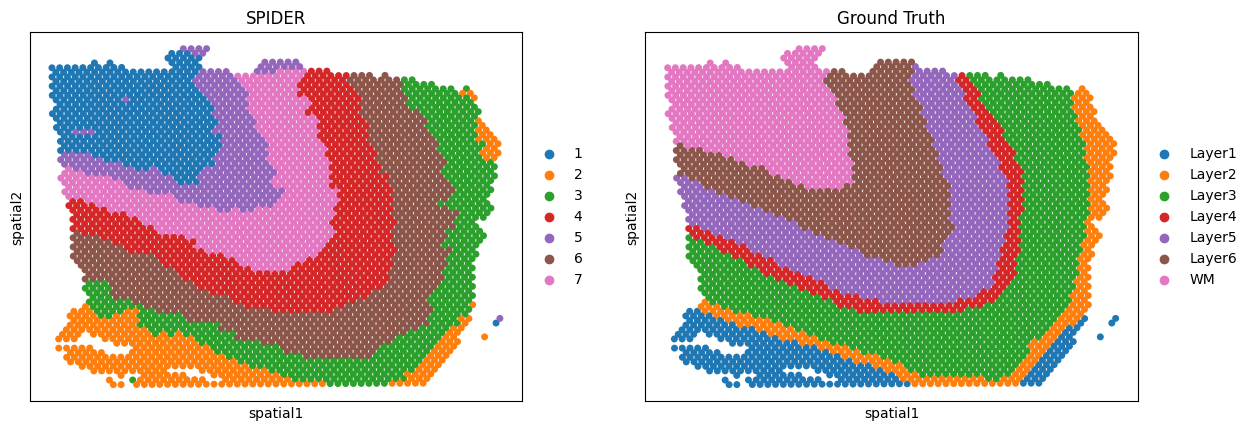

In [ ]:
sc.pp.normalize_total(std,layer='SPIDER',target_sum=1e4)
sc.pp.log1p(std,layer='SPIDER')
std.obsm['SPIDER_pca'] = sc.tl.pca(std.layers['SPIDER'], n_comps=20, svd_solver="arpack", random_state=3156)
import STAGATE_pyG as STAGATE
STAGATE.mclust_R(std, used_obsm='SPIDER_pca',num_cluster=std.uns['num_cluster'],modelNames="EEI",random_seed=3156)
sc.pl.embedding(std,basis="spatial", color=["mclust","Ground Truth"],s=100, title=["SPIDER","Ground Truth"])

In [19]:
ARI = adjusted_rand_score(std.obs['mclust'], std.obs['Ground Truth'])
NMI = normalized_mutual_info_score(std.obs['mclust'], std.obs['Ground Truth'])
HS = homogeneity_score(std.obs['mclust'], std.obs['Ground Truth'])
print(ARI, NMI, HS)

0.5853560019294005 0.7200466609811358 0.7038149983573451
